In [ ]:
## Data Initializing

In [1]:
import pandas as pd
import numpy as np
import data_handler as dh
import model as md
import time
import matplotlib.pyplot as plt
from matplotlib import rc
import pickle

In [2]:
import importlib
importlib.reload(dh)
importlib.reload(md)

<module 'model' from '/home/mkub/Meruza_ubuntu/GitHub/TransportNet/Stable Dynamic & Beckman/model.py'>

In [2]:
import numba
numba.__version__

'0.49.0'

# Beckmann model

parameter $\mu = 0.25$

In [3]:
beckmann_save = 'beckmann_results/'

In [4]:
net_name = 'Anaheim_net.tntp'
trips_name = 'Anaheim_trips.tntp'

handler = dh.DataHandler()
graph_data = handler.GetGraphData(net_name, columns = ['init_node', 'term_node', 'capacity', 'free_flow_time'])
graph_correspondences, total_od_flow = handler.GetGraphCorrespondences(trips_name)

model = md.Model(graph_data, graph_correspondences, 
                    total_od_flow, mu = 0.25, rho = 0.15)

graph_data['graph_table'].head()

,init_node,init_node_thru,term_node,term_node_thru,capacity,free_flow_time
0,1,False,117,True,9000.0,1.090458
1,2,False,87,True,9000.0,1.090458
2,3,False,74,True,9000.0,1.090458
3,4,False,233,True,9000.0,1.090458
4,5,False,165,True,9000.0,1.090458


## Frank-Wolfe method

In [4]:
#new prox oracle etc. t_weighted !!
assert(model.mu == 0.25)
max_iter = 10000

print('Frank-Wolfe without stopping criteria')
solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                 'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'fwm', solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

Frank-Wolfe without stopping criteria
Oracles created...
Frank-Wolfe algorithm...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 2000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.588403
Duality_gap / Duality_gap_init = 1.22754e-05

Iterations number: 4000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.289695
Duality_gap / Duality_gap_init = 6.0437e-06

Iterations number: 6000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.192024
Duality_gap / Duality_gap_init = 4.00605e-06

Iterations number: 8000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.143654
Duality_gap / Duality_gap_init = 2.99694e-06

Iterations number: 10000
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 0.114635
Duality_gap / Duality_gap_init = 2.39155e-06
Result: iterations number exceeded Total iters: 10000
Primal

In [5]:
#with open(beckmann_save + 'anaheim_result_' + 'fwm_t_weighted' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
#    pickle.dump(result, f)

In [15]:
with open(beckmann_save + 'anaheim_result_fwm_t_weighted_max_iter_10000_beckmann.pickle', 'rb') as f:
    result = pickle.load(f)

__Checking the result with the answer from https://github.com/bstabler/TransportationNetworks__ 

In [16]:
answer = handler.ReadAnswer('Anaheim_flow.tntp')
delta = abs(answer['flows'] - result['flows'])
print('Flows:')
print('total_od_flow =', total_od_flow)
print('min_i |f - f^*|[i] =', np.min(delta))
print('max_i |f - f^*|[i] =', np.max(delta))
print('||f - f^*||_1 / ||f^*||_1 =', np.linalg.norm(result['flows'] - answer['flows'], ord = 1) / np.linalg.norm(answer['flows'], ord = 1))
print('||f - f^*||_2 / ||f^*||_2 =', np.linalg.norm(delta) / np.linalg.norm(answer['flows']))
print('Times:')
delta = abs(answer['times'] - result['times'])
print('min_i |t - t^*|[i] =', np.min(delta))
print('max_i |t - t^*|[i] =', np.max(delta))
print('||t - t^*||_1 =', np.sum(delta))

Flows:
total_od_flow = 104694.4
min_i |f - f^*|[i] = 0.0
max_i |f - f^*|[i] = 0.6930271191049542
||f - f^*||_1 / ||f^*||_1 = 1.5773880137928968e-05
||f - f^*||_2 / ||f^*||_2 = 3.110964791145533e-05
Times:
min_i |t - t^*|[i] = 0.0
max_i |t - t^*|[i] = 5.241011209300428e-05
||t - t^*||_1 = 0.0006019054672867438


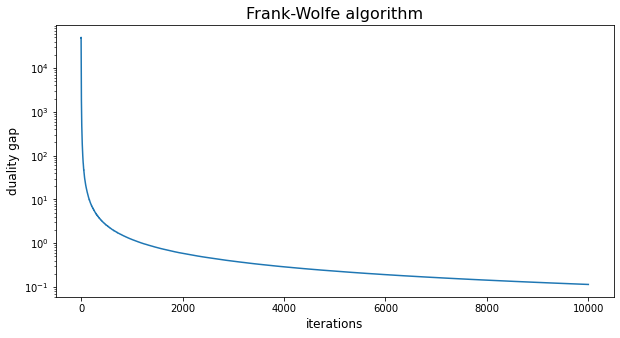

In [21]:
dual_gaps = np.array(result['history']['dual_gap'])
iters = np.array(result['history']['iter'])
plt.figure(figsize = (10, 5))
plt.plot(iters, dual_gaps)
plt.title('Frank-Wolfe algorithm', fontsize = 16)
plt.ylabel('duality gap', fontsize = 12)
plt.xlabel('iterations', fontsize = 12)
plt.yscale('log')
plt.show()

In [3]:
epsilons = np.logspace(3,-0.5,8)
epsilons

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01])

## Universal Similar Triangles

In [31]:
assert(model.mu == 0.25)
max_iter = 10000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 2000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 1000.0
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
Result: success Total iters: 12
Primal_func_value = 1.28631e+06
Dual_func_value = -1.28553e+06
Duality_gap = 775.701
Duality_gap / Duality_gap_init = 0.0161829
Oracle elapsed time: 3 sec
Elapsed time: 3 sec
Time ratio = 3.0464158854257204
Flow excess = 1.1585339704654092

eps_abs = 316.22776601683796
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4
Result: success Total iters: 20
Primal_func_value = 1.28611e+06
Dual_func_value = -1.28582e+06
Duality_gap = 292.674
Duality_gap / Duality_gap_init = 0.00610586
Oracle elapsed time: 7 sec
Elapsed time: 7 sec
Time ratio = 3.1357283581860322
Flow excess = 1.058153077611339

eps_abs = 100.0
Composite optimization...
Oracles created...
Universal similar triangl

In [15]:
assert(model.mu == 0.25)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    if index < len(epsilons) - 1:
        continue
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ustm', composite = True, solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ustm' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 0.31622776601683794
Composite optimization...
Oracles created...
Universal similar triangles method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 4000
Inner iterations number: 8013
Primal_func_value = 1.28613e+06
Dual_func_value = -1.28575e+06
Duality_gap = 376.62
Duality_gap / Duality_gap_init = 0.00785715

Iterations number: 8000
Inner iterations number: 16011
Primal_func_value = 1.28607e+06
Dual_func_value = -1.28593e+06
Duality_gap = 142.724
Duality_gap / Duality_gap_init = 0.00297755

Iterations number: 12000
Inner iterations number: 24010
Primal_func_value = 1.28605e+06
Dual_func_value = -1.286e+06
Duality_gap = 54.5036
Duality_gap / Duality_gap_init = 0.00113707

Iterations number: 16000
Inner iterations number: 32009
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28602e+06
Duality_gap = 20.5112
Duality_gap / Duality_gap_init = 0.000427911

Iterations number: 20000
Inner iterations number: 40009
Primal_func_v

In [59]:
#index += 8
#epsilons = np.logspace(4, 3, 5)[:-1]
#epsilons

array([10000.        ,  5623.4132519 ,  3162.27766017,  1778.27941004])

## Universal Gradient Descent

In [6]:
epsilons = np.logspace(3,1.5,7)
epsilons

array([1000.        ,  562.34132519,  316.22776602,  177.827941  ,
        100.        ,   56.23413252,   31.6227766 ])

In [7]:
#weighted t added
assert(model.mu == 0.25)
max_iter = 40000
for index, eps_abs in enumerate(epsilons):
    print('eps_abs =', eps_abs)
    solver_kwargs = {'eps_abs': eps_abs,
                     'max_iter': max_iter, 'stop_crit': 'dual_gap',
                     'verbose' : True, 'verbose_step': 4000, 'save_history' : True}
    tic = time.time()
    result = model.find_equilibrium(solver_name = 'ugd', composite = True, solver_kwargs = solver_kwargs)
    toc = time.time()
    print('Elapsed time: {:.0f} sec'.format(toc - tic))
    print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
    print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')
    
    result['eps_abs'] = eps_abs
    result['elapsed_time'] = toc - tic
    with open(beckmann_save + 'anaheim_result_' + 'ugd' + '_eps_abs_' + str(index) + '_beckmann.pickle', 'wb') as f:
        pickle.dump(result, f)

eps_abs = 1000.0
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 74
Primal_func_value = 1.28629e+06
Dual_func_value = -1.2853e+06
Duality_gap = 990.459
Duality_gap / Duality_gap_init = 0.0206632
Oracle elapsed time: 29 sec
Elapsed time: 30 sec
Time ratio = 2.545876295139248
Flow excess = 1.179200110558324

eps_abs = 562.341325190349
Composite optimization...
Oracles created...
Universal gradient descent method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Result: success
Total iters: 196
Primal_func_value = 1.28619e+06
Dual_func_value = -1.28564e+06
Duality_gap = 556.132
Duality_gap / Duality_gap_init = 0.0116022
Oracle elapsed time: 79 sec
Elapsed time: 80 sec
Time ratio = 2.7413540508489267
Flow excess = 1.128239661185849

eps_abs = 316.22776601683796
Composite optimization...
Oracles created...
Universal gra

In [57]:
#index += 7
#epsilons = np.logspace(4, 3, 5)[:-1]
#epsilons

array([10000.        ,  5623.4132519 ,  3162.27766017,  1778.27941004])

## Weighted Dual Averages

### Composite optimization

In [7]:
assert(model.mu == 0.25)
max_iter = 40000
solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history': True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = True, solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(beckmann_save + 'anaheim_result_' + 'wda' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

Composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 4000
Inner iterations number: 0
Primal_func_value = 1.28604e+06
Dual_func_value = -1.28602e+06
Duality_gap = 18.1014
Duality_gap / Duality_gap_init = 0.000377636

Iterations number: 8000
Inner iterations number: 0
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28602e+06
Duality_gap = 9.47457
Duality_gap / Duality_gap_init = 0.000197661

Iterations number: 12000
Inner iterations number: 0
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 6.45904
Duality_gap / Duality_gap_init = 0.00013475

Iterations number: 16000
Inner iterations number: 0
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06
Duality_gap = 4.91314
Duality_gap / Duality_gap_init = 0.000102499

Iterations number: 20000
Inner iterations number: 0
Primal_func_value = 1.28603e+06
Dual_func_value = -1.28603e+06

### Non-composite optimization

In [9]:
assert(model.mu == 0.25)
max_iter = 40000
solver_kwargs = {'max_iter' : max_iter, 'stop_crit': 'max_iter',
                 'verbose': True, 'verbose_step': 4000, 'save_history' : True}
tic = time.time()
result = model.find_equilibrium(solver_name = 'wda', composite = False, solver_kwargs = solver_kwargs)
toc = time.time()
print('Elapsed time: {:.0f} sec'.format(toc - tic))
print('Time ratio =', np.max(result['times'] / graph_data['graph_table']['free_flow_time']))
print('Flow excess =', np.max(result['flows'] / graph_data['graph_table']['capacity']) - 1, end = '\n\n')

result['elapsed_time'] = toc - tic
with open(beckmann_save + 'anaheim_result_' + 'wda_noncomposite' + '_max_iter_' + str(max_iter) + '_beckmann.pickle', 'wb') as f:
    pickle.dump(result, f)

Non-composite optimization...
Oracles created...
Weighted dual averages method...
Primal_init = 1.29606e+06
Dual_init = -1.24813e+06
Duality_gap_init = 47933.4

Iterations number: 4000
Inner iterations number: 0
Primal_func_value = 1.2868e+06
Dual_func_value = -1.28265e+06
Duality_gap = 4156.14
Duality_gap / Duality_gap_init = 0.0867066

Iterations number: 8000
Inner iterations number: 0
Primal_func_value = 1.28641e+06
Dual_func_value = -1.28391e+06
Duality_gap = 2495.95
Duality_gap / Duality_gap_init = 0.0520713

Iterations number: 12000
Inner iterations number: 0
Primal_func_value = 1.28628e+06
Dual_func_value = -1.2844e+06
Duality_gap = 1884.2
Duality_gap / Duality_gap_init = 0.0393086

Iterations number: 16000
Inner iterations number: 0
Primal_func_value = 1.28622e+06
Dual_func_value = -1.28466e+06
Duality_gap = 1558.96
Duality_gap / Duality_gap_init = 0.0325234

Iterations number: 20000
Inner iterations number: 0
Primal_func_value = 1.28619e+06
Dual_func_value = -1.28484e+06
Duali

## Plots

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
import numpy as np
beckmann_save = 'beckmann_results/'

In [30]:
results = {}

for method in ['ustm', 'ugd']:
    results[method] = {}
    results[method]['iters'] = []
    results[method]['inner_iters'] = []
    results[method]['epsilon'] = []
    results[method]['dual_gap_init'] = []
    i = 0
    while True:
        try:
            with open(beckmann_save + 'anaheim_result_' + method + '_eps_abs_'
                      + str(i) + '_beckmann.pickle', 'rb') as f:
                result = pickle.load(f)
                results[method]['epsilon'].append(result['eps_abs'])
                results[method]['iters'].append(result['iter_num'])
                results[method]['inner_iters'].append(result['history'].get('inner_iters')[-1])
                results[method]['dual_gap_init'].append(result['history'].get('dual_gap')[0])
        except FileNotFoundError:
            break
        i += 1


In [31]:
for method in ['wda', 'wda_noncomposite']:
    results[method] = {}
    with open(beckmann_save + 'anaheim_result_' + method + '_max_iter_40000_beckmann.pickle', 'rb') as f:
        result = pickle.load(f)
        results[method]['epsilon'] = result['history'].get('dual_gap')
        results[method]['iters'] = result['history'].get('iter')
        results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

In [32]:
method = 'fwm'
with open(beckmann_save + 'anaheim_result_fwm_t_weighted_max_iter_10000_beckmann.pickle', 'rb') as f:
    results[method] = {}
    result = pickle.load(f)
    results[method]['epsilon'] = result['history'].get('dual_gap')
    results[method]['iters'] = result['history'].get('iter')
    results[method]['dual_gap_init'] = result['history'].get('dual_gap')[0]

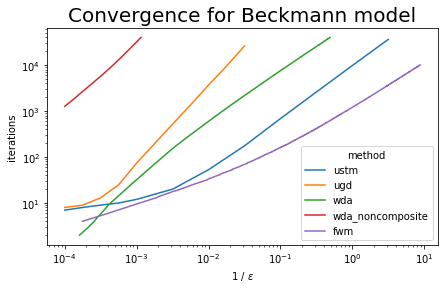

In [33]:
plt.figure(figsize=(7,4))
plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    y = np.array(data['iters'])
    ind = np.nonzero(1 / x <= eps_upper)
    plt.plot(x[ind], y[ind], label = method)
plt.legend(title = 'method')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$')
plt.ylabel('iterations')
plt.show()

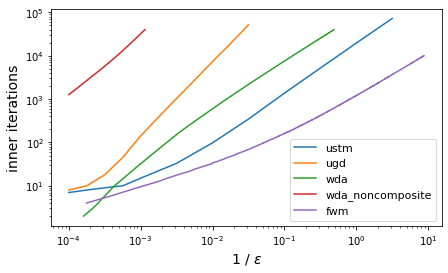

In [34]:
#inner iterations vs absolute accuracy = eps_abs
plt.figure(figsize=(7,4))
#plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 1e4
for method, data in results.items():
    x = 1. / np.array(data['epsilon'])
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    ind = np.nonzero(1 / x <= eps_upper)
    plt.plot(x[ind], y[ind], label = method)
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('beckmann_convergence.jpg', dpi = 300)
plt.show()

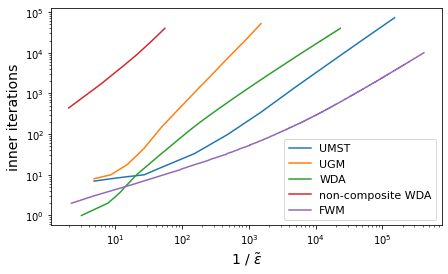

In [40]:
#inner iterations vs relative accuracy = eps_abs / dual_gap_init
plt.figure(figsize=(7,4))
#plt.title('Convergence for Beckmann model', fontsize=20)
eps_upper = 0.5

method_names = {'ustm' : 'UMST', 'ugd' : 'UGM', 'wda' : 'WDA',
                'wda_noncomposite' : 'non-composite WDA', 'fwm' : 'FWM'}
for method, data in results.items():
    x = 1. / (np.array(data['epsilon']) / np.array(data['dual_gap_init']))
    if 'inner_iters' in data:
        y = np.array(data['inner_iters'])
    else:
        y = np.array(data['iters'])
    ind = np.nonzero(1 / x <= eps_upper)
    plt.plot(x[ind], y[ind], label = method_names[method])
plt.legend(prop = {'size' : 11})
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'1 / $\tilde\varepsilon$', fontsize = 14)
plt.ylabel('inner iterations', fontsize = 14)
#plt.savefig('beckmann_convergence_rel_eps.jpg', dpi = 300)
plt.show()